In [103]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical

In [81]:
# Set the batch size, number of epochs.
batch_size = 32
num_classes = 2
epochs = 40
num_predictions = 20

In [82]:
# Load the Cats vs. Dogs dataset
dataset, info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

# Access the splits
train_, test_ = dataset[0], dataset[1]
print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

In [83]:
train_

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [84]:
test_

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [85]:
# Print the number of images in each split
num_train_images = info.splits['train[:80%]'].num_examples
num_test_images = info.splits['train[80%:]'].num_examples
num_images = info.splits['train'].num_examples
print(f'Total Number of images in the dataset: {num_images}')
print(f'Number of images in the training set: {num_train_images}')
print(f'Number of images in the testing set: {num_test_images}')

Total Number of images in the dataset: 23262
Number of images in the training set: 18610
Number of images in the testing set: 4652


In [86]:
# Function to resize images
def resize_image(image, label, img_size=(32, 32)):
    image = tf.image.resize(image, img_size)
    return image, label

# Apply resizing to the dataset
img_size = (32, 32)
train_ = train_.map(lambda image, label: resize_image(image, label, img_size))
test_ = test_.map(lambda image, label: resize_image(image, label, img_size))


In [87]:
# Convert the dataset to NumPy arrays
def dataset_to_numpy(ds):
    images, labels = [], []
    for image, label in ds:
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Convert the entire datasets to NumPy arrays
x_train, y_train = dataset_to_numpy(train_)
x_test, y_test = dataset_to_numpy(test_)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(18610, 32, 32, 3) (18610,)
(4652, 32, 32, 3) (4652,)


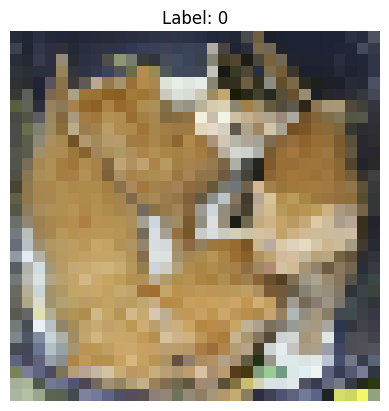

In [89]:
# Show one image from x_train
plt.imshow(x_train[6].astype("uint8"))
plt.title(f"Label: {y_train[6]}")
plt.axis('off')  # Hide axes
plt.show()


In [90]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [91]:
print(y_train.shape)
print(y_test.shape)

(18610, 2)
(4652, 2)


In [92]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [93]:
# Set the CNN model

batch_size = None

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=x_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
# softmax
model.add(layers.Dense(2, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 batch_normalization_13 (Ba  (None, 16, 16, 64)       

In [94]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [95]:
#train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [96]:
x_train = x_train.astype('float32') # Conversion to float type from integer type.
x_test = x_test.astype('float32')
x_train /= 255.0 # Division by 255
x_test /= 255.0

In [97]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value.
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('best_model.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [98]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

print(x_train.shape)
print(x_test.shape)

(18610, 32, 32, 3)
(4652, 32, 32, 3)


Epoch 1/100
582/582 [==============================] - ETA: 0s - loss: 0.7611 - accuracy: 0.5882
Epoch 1: val_loss improved from inf to 1.11307, saving model to best_model.h5
582/582 [==============================] - 117s 194ms/step - loss: 0.7611 - accuracy: 0.5882 - val_loss: 1.1131 - val_accuracy: 0.5604
Epoch 2/100
582/582 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.6475
Epoch 2: val_loss improved from 1.11307 to 0.81006, saving model to best_model.h5
582/582 [==============================] - 97s 167ms/step - loss: 0.6305 - accuracy: 0.6475 - val_loss: 0.8101 - val_accuracy: 0.5015
Epoch 3/100
582/582 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6693
Epoch 3: val_loss improved from 0.81006 to 0.63870, saving model to best_model.h5
582/582 [==============================] - 97s 167ms/step - loss: 0.6036 - accuracy: 0.6693 - val_loss: 0.6387 - val_accuracy: 0.6707
Epoch 4/100
582/582 [==============================] - ETA: 0s -

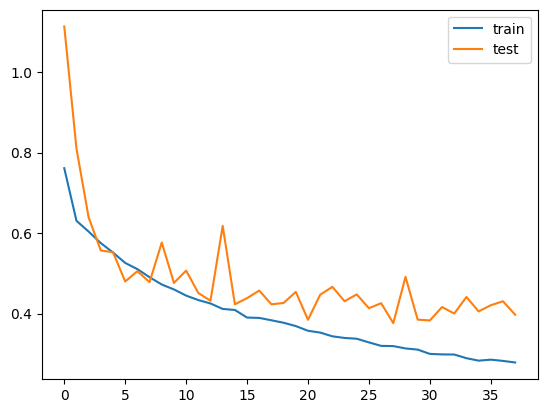

In [99]:
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [100]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

146/146 [==============================] - 6s 38ms/step - loss: 0.3972 - accuracy: 0.8336
Test loss: 0.39720022678375244
Test accuracy: 0.8336199522018433


In [101]:
predictions = model.predict(x_test)

146/146 [==============================] - 6s 38ms/step


In [104]:
preds = pd.DataFrame(predictions)
preds

,0,1
0,0.007542,0.992458
1,0.360925,0.639075
2,0.011239,0.988761
3,0.020065,0.979935
4,0.382230,0.617770
...,...,...
4647,0.995630,0.004370
4648,0.012998,0.987002
4649,0.639584,0.360416
4650,0.171237,0.828763


In [ ]:
def preprocess_and_predict(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    img_array /= 255.0  # Normalize the image

    prediction = model.predict(img_array)
    return prediction

# Example usage:
# Assuming 'new_image.jpg' is the path to a new image
image_path = 'C://Users//ay152//Downloads//52.jpg'
prediction = preprocess_and_predict(image_path, model)
print(f'Prediction: {prediction}')